In [ ]:
!pip install textblob
!pip install textblob_fr
!pip install transformers

In [ ]:
["pain", "maison"]

In [ ]:
!pip install sentencepiece

In [ ]:
# To read csv file from Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
import pandas as pd 
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
import json
import time
import torch
import datetime
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/1WC2oxayicxuXWou3MxIbLohSopkDHEgT/view?usp=sharing
fileDownload = drive.CreateFile({'id':'1WC2oxayicxuXWou3MxIbLohSopkDHEgT'})
fileDownload.GetContentFile('restaurants_bars_category.csv')


In [ ]:
df = pd.read_csv('restaurants_bars_category.csv',index_col=0)

In [ ]:
df.columns

Index(['Title', 'Body', 'Stars', 'Rated', 'Date Posted', 'Time Posted'], dtype='object')

In [ ]:
df.drop(['Title', 'Stars', 'Rated', 'Date Posted', 'Time Posted'], axis=1, inplace=True)

In [ ]:
df.head(5)

,Body
0,Commandes multiples et à chaque fois parfait !...
1,Super ! Biscuit au top !
2,Un cadeau original et surprenant pour la fête ...
3,Très beau rendu et très bons biscuits ! les ma...
4,"Super contente du résultat, ma grand-mère étai..."


In [ ]:
AComment=[]
for comment in df['Body'].apply(str):
    mots = []
    for word in  re.sub("\W"," ",comment ).split():
        mots.append(word)
    AComment.append(mots)

In [ ]:
df['mots'] = AComment

In [ ]:
df.head(5)

,Body,mots
0,Commandes multiples et à chaque fois parfait !...,"[Commandes, multiples, et, à, chaque, fois, pa..."
1,Super ! Biscuit au top !,"[Super, Biscuit, au, top]"
2,Un cadeau original et surprenant pour la fête ...,"[Un, cadeau, original, et, surprenant, pour, l..."
3,Très beau rendu et très bons biscuits ! les ma...,"[Très, beau, rendu, et, très, bons, biscuits, ..."
4,"Super contente du résultat, ma grand-mère étai...","[Super, contente, du, résultat, ma, grand, mèr..."


In [ ]:
stop_words=set(STOP_WORDS)

deselect_stop_words = ['n\'','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

In [ ]:
AllfilteredComment=[]
for comment in df['mots']:
    filteredComment = [w for w in comment if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredComment.append(' '.join(filteredComment))

In [ ]:
df['motsFiltrer'] = AllfilteredComment

In [ ]:
df.head(5)

,Body,mots,motsFiltrer
0,Commandes multiples et à chaque fois parfait !...,"[Commandes, multiples, et, à, chaque, fois, pa...",Commandes multiples fois parfait Rapidement ex...
1,Super ! Biscuit au top !,"[Super, Biscuit, au, top]",Super Biscuit top
2,Un cadeau original et surprenant pour la fête ...,"[Un, cadeau, original, et, surprenant, pour, l...",Un cadeau original surprenant fête mamies Les ...
3,Très beau rendu et très bons biscuits ! les ma...,"[Très, beau, rendu, et, très, bons, biscuits, ...",Très rendu bons biscuits mamies adoré attentio...
4,"Super contente du résultat, ma grand-mère étai...","[Super, contente, du, résultat, ma, grand, mèr...",Super contente résultat grand mère heureuse Merci


In [ ]:
senti_list = []
for i in df['motsFiltrer']:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral') 

In [ ]:
df['sentiment'] = senti_list

In [ ]:
df.head(5)

,Body,mots,motsFiltrer,sentiment
0,Commandes multiples et à chaque fois parfait !...,"[Commandes, multiples, et, à, chaque, fois, pa...",Commandes multiples fois parfait Rapidement ex...,Positive
1,Super ! Biscuit au top !,"[Super, Biscuit, au, top]",Super Biscuit top,Positive
2,Un cadeau original et surprenant pour la fête ...,"[Un, cadeau, original, et, surprenant, pour, l...",Un cadeau original surprenant fête mamies Les ...,Positive
3,Très beau rendu et très bons biscuits ! les ma...,"[Très, beau, rendu, et, très, bons, biscuits, ...",Très rendu bons biscuits mamies adoré attentio...,Positive
4,"Super contente du résultat, ma grand-mère étai...","[Super, contente, du, résultat, ma, grand, mèr...",Super contente résultat grand mère heureuse Merci,Positive


In [ ]:
fig = px.histogram(df, x="sentiment",color="sentiment", width=1000)
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

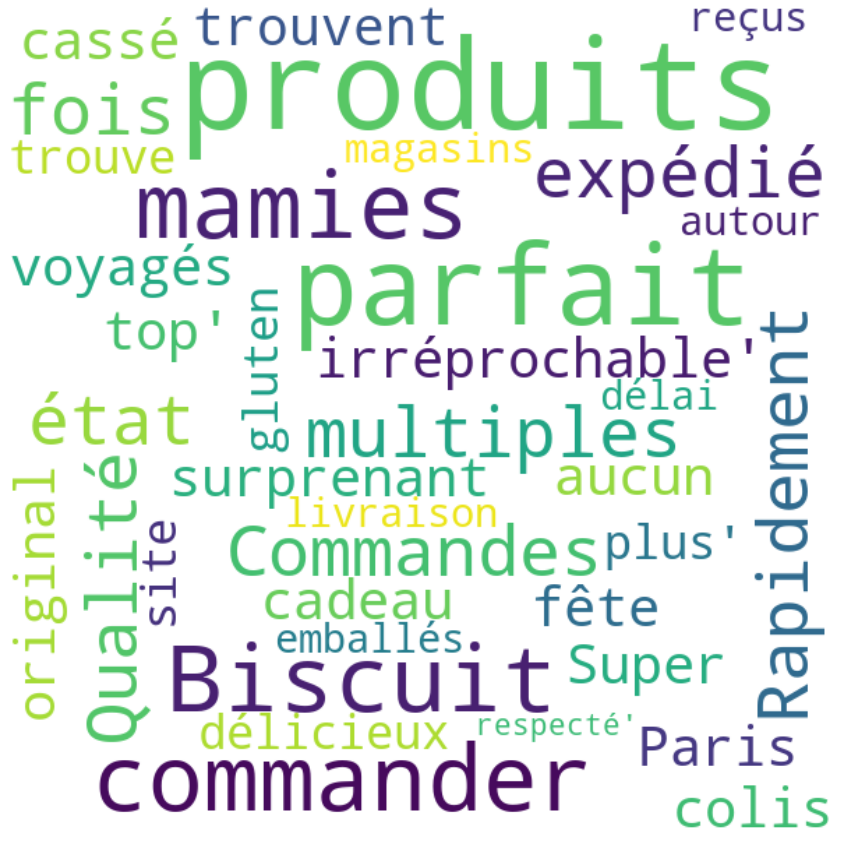

In [ ]:
text = str(df['motsFiltrer'].values)
def plot_word_cloud(text) :
    
    # Définir le calque du nuage des mots
    wc = WordCloud(width=600,height=600,background_color="white", max_words=100, stopwords=stop_words, max_font_size=90,collocations = False, random_state=42)

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (15,20))
    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.show()
plot_word_cloud(text)

In [ ]:
df['sentiment'] = df['sentiment'].replace('Positive',1)
df['sentiment'] = df['sentiment'].replace('Neutral',2)
df['sentiment'] = df['sentiment'].replace('Negative',0)

In [ ]:
df.head(5)

,Body,mots,motsFiltrer,sentiment
0,Commandes multiples et à chaque fois parfait !...,"[Commandes, multiples, et, à, chaque, fois, pa...",Commandes multiples fois parfait Rapidement ex...,1
1,Super ! Biscuit au top !,"[Super, Biscuit, au, top]",Super Biscuit top,1
2,Un cadeau original et surprenant pour la fête ...,"[Un, cadeau, original, et, surprenant, pour, l...",Un cadeau original surprenant fête mamies Les ...,1
3,Très beau rendu et très bons biscuits ! les ma...,"[Très, beau, rendu, et, très, bons, biscuits, ...",Très rendu bons biscuits mamies adoré attentio...,1
4,"Super contente du résultat, ma grand-mère étai...","[Super, contente, du, résultat, ma, grand, mèr...",Super contente résultat grand mère heureuse Merci,1


In [ ]:
df.drop( df[ df['sentiment'] == 2 ].index, inplace=True)

In [ ]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 1
device = torch.device('cuda')

In [ ]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [ ]:
# Creates list of texts and labels
text = df['Body'].to_list()
labels = df['sentiment'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,truncation=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

In [ ]:
tokenizer.encode?

In [ ]:
input_ids 

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(input_ids, labels, attention_masks,
                                                            random_state=42, test_size=0.1)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

In [ ]:
type(model)

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

print("Model saved!")
torch.save(model.state_dict(), "/content/drive/MyDrive/truspilot_category_data/sentiments_pytorch.pt")

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/truspilot_category_data/sentiments_pytorch.pt'))


<All keys matched successfully>

In [ ]:
import pandas as pd

In [ ]:
df_category = pd.read_csv('/content/drive/MyDrive/truspilot_category_data/shopping_fashion_category.csv')

In [ ]:
df_category.head(5)

,Title,Body,Rating,Date
0,\n Qualité maintenue\n ...,Qualité maintenue: très appréciable!!!!,5 étoiles : excellent,2021-03-17T16:12:08+00:00
1,\n Ravie 😀 et enchantée...,-,5 étoiles : excellent,2021-03-17T16:08:31+00:00
2,\n Excellent!\n ...,Excellent!aucun désagrément.service rapide.,5 étoiles : excellent,2021-03-17T16:01:40+00:00
3,\n Bon expérience clien...,-,5 étoiles : excellent,2021-03-17T15:53:09+00:00
4,\n rapide et efficace\n...,-,5 étoiles : excellent,2021-03-17T15:47:01+00:00


In [ ]:
len(df_category)

5242

In [ ]:
df_category = df_category.sample(frac =.2) 

In [ ]:
len(df_category)

1048

In [ ]:
df_category['avis'] = df_category['Title'] + df_category['Body']

In [ ]:
df_category.head(5)

,Title,Body,Rating,Date,avis
4742,\n Celinni Suisse\n ...,J’ai été agréablement surprise par la qualité ...,5 étoiles : excellent,2021-03-12T21:14:12+00:00,\n Celinni Suisse\n ...
2336,\n Génial envie de reco...,C'était vraiment super le seul problème est l...,4 étoiles : bien,2018-01-27T23:48:57Z,\n Génial envie de reco...
3669,\n Magnifique\n ...,"Magnifique, superbe composition, très délicat ...",5 étoiles : excellent,2021-03-07T19:57:11+00:00,\n Magnifique\n ...
2001,\n Formation à recomman...,Formation très intéressante et très abordable ...,5 étoiles : excellent,2020-03-17T11:23:26+00:00,\n Formation à recomman...
3025,\n Fleurs de qualités\n...,Fleurs de qualités té. Les fleurs sont arrivés...,4 étoiles : bien,2020-09-30T12:08:31+00:00,\n Fleurs de qualités\n...


In [ ]:

df_category.drop(['Title', 'Body', 'Rating', 'Date'], axis=1, inplace=True)

In [ ]:
df_category.head(5)

,avis
4742,\n Celinni Suisse\n ...
2336,\n Génial envie de reco...
3669,\n Magnifique\n ...
2001,\n Formation à recomman...
3025,\n Fleurs de qualités\n...


In [ ]:
comments = df_category['avis'].reset_index(drop=True)

In [ ]:
comments

0       \n                        Celinni Suisse\n    ...
1       \n                        Génial envie de reco...
2       \n                        Magnifique\n        ...
3       \n                        Formation à recomman...
4       \n                        Fleurs de qualités\n...
                              ...                        
1043    \n                        Une très bonne expér...
1044    \n                        Bien plus qu'un joai...
1045    \n                        Supers conseils pour...
1046    \n                        Chic time a fait pre...
1047    \n                        Je serai client à vi...
Name: avis, Length: 1048, dtype: object

In [ ]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment,add_special_tokens=True,max_length=MAX_LEN) for comment in comments]
# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks 
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

In [ ]:
# Apply the finetuned model (Camembert)
flat_pred = []
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(prediction_inputs.to(device),token_type_ids=None, attention_mask=prediction_masks.to(device))
    logits = outputs[0]
    logits = logits.detach().cpu().numpy() 
    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [ ]:
print(flat_pred)

In [ ]:
print(comments.reset_index())

      index                                               avis
0         0  \n                        Celinni Suisse\n    ...
1         1  \n                        Génial envie de reco...
2         2  \n                        Magnifique\n        ...
3         3  \n                        Formation à recomman...
4         4  \n                        Fleurs de qualités\n...
...     ...                                                ...
1043   1043  \n                        Une très bonne expér...
1044   1044  \n                        Bien plus qu'un joai...
1045   1045  \n                        Supers conseils pour...
1046   1046  \n                        Chic time a fait pre...
1047   1047  \n                        Je serai client à vi...

[1048 rows x 2 columns]


In [ ]:
for i in range(len(flat_pred)):
    print('Comment: ', comments[i])
    print('Label', flat_pred[i])